In [3]:
from superduperdb.mongodb.client import SuperDuperClient
from IPython.display import display

c = SuperDuperClient()
docs = c.yondo.documents

In [5]:
import torch


class Target(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def preprocess(self, value):
        return torch.tensor(float(value))
    
    def forward(self, x):
        return x
    
    
class PersonDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(1024, 1)
        
    def preprocess(self, value):
        return torch.tensor(value).type(torch.float)
    
    def forward(self, x):
        return self.linear(x)[:, 0]
    
    def postprocess(self, x):
        return x.item() > 0.5


docs.create_model(
    'target',
    Target(),
    serializer='dill',
)

docs.create_model(
    'person_detector',
    PersonDetector(),
    serializer='dill',
)

In [6]:
pos_weight = docs.count_documents({'person': True}) / docs.count_documents({'person': False})

docs.create_objective('bce', torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight)))

In [7]:
docs.create_metric('accuracy', lambda x, y: x == y, serializer='dill')

In [8]:
job_ids = docs.create_imputation(
    'person_imputation',
    'person_detector',
    '_base',
    'target',
    'person',
    objective='bce',
    metrics=['accuracy'],
    filter_={'person': {'$exists': 1}},
    trainer_kwargs={'features': {'_base': 'clip'}, 'log_interval': 50},
)

In [9]:
job_ids

['db8314af-8f1f-49fd-829e-53c48f06e9b0',
 '4fe6be13-7b64-43ce-96c0-c10b1b4c528a']

In [11]:
docs.watch_job(job_ids[0])

fold: VALID; iteration: 0; epoch: 0; objective: 0.9003247618675232; 
fold: TRAIN; iteration: 0; epoch: 0; objective: 0.8753836154937744; 
fold: TRAIN; iteration: 50; epoch: 5; objective: 0.9088515639305115; 
fold: TRAIN; iteration: 100; epoch: 10; objective: 0.8730158805847168; 
fold: TRAIN; iteration: 150; epoch: 15; objective: 0.8381669521331787; 
fold: TRAIN; iteration: 200; epoch: 20; objective: 0.8354043364524841; 
fold: TRAIN; iteration: 250; epoch: 25; objective: 0.8374389410018921; 
fold: TRAIN; iteration: 300; epoch: 30; objective: 0.8276808261871338; 
fold: TRAIN; iteration: 350; epoch: 35; objective: 0.8185846209526062; 
fold: TRAIN; iteration: 400; epoch: 40; objective: 0.8080307245254517; 
fold: TRAIN; iteration: 450; epoch: 45; objective: 0.7994518876075745; 
fold: TRAIN; iteration: 500; epoch: 50; objective: 0.7974228858947754; 
fold: TRAIN; iteration: 550; epoch: 55; objective: 0.788723349571228; 
fold: TRAIN; iteration: 600; epoch: 60; objective: 0.7726286053657532; 
f

fold: TRAIN; iteration: 5250; epoch: 525; objective: 0.5045676231384277; 
fold: TRAIN; iteration: 5300; epoch: 530; objective: 0.47652295231819153; 
fold: TRAIN; iteration: 5350; epoch: 535; objective: 0.392551451921463; 
fold: TRAIN; iteration: 5400; epoch: 540; objective: 0.5161490440368652; 
fold: TRAIN; iteration: 5450; epoch: 545; objective: 0.45348647236824036; 
fold: TRAIN; iteration: 5500; epoch: 550; objective: 0.4917735159397125; 
fold: TRAIN; iteration: 5550; epoch: 555; objective: 0.46030938625335693; 
fold: TRAIN; iteration: 5600; epoch: 560; objective: 0.47345611453056335; 
fold: TRAIN; iteration: 5650; epoch: 565; objective: 0.4312094748020172; 
fold: TRAIN; iteration: 5700; epoch: 570; objective: 0.44953837990760803; 
fold: TRAIN; iteration: 5750; epoch: 575; objective: 0.4021960496902466; 
fold: TRAIN; iteration: 5800; epoch: 580; objective: 0.5077970027923584; 
fold: TRAIN; iteration: 5850; epoch: 585; objective: 0.43265801668167114; 
fold: TRAIN; iteration: 5900; epo

In [12]:
docs.list_models()

['clip', 'person_detector', 'silhouettes', 'target']

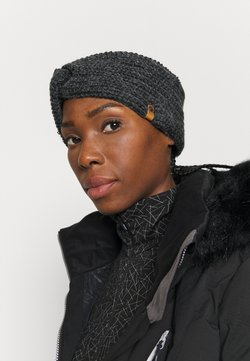

True

In [14]:
_id = next(docs.aggregate([
    {'$match': {}},
    {'$sample': {'size': 1}},
    {'$project': {'_id': 1}}
]))['_id']

r = docs.find_one({'_id': _id})

display(r['img'])
docs.apply_model('person_detector', r['_outputs']['_base']['clip'])

In [15]:
docs.delete_imputation('person_imputation', force=True)
docs.delete_objective('bce', force=True)
docs.delete_metric('accuracy', force=True)
docs.delete_model('person_detector', force=True)
docs.delete_model('target', force=True)